# $\textbf{Data Load and Inspection}$

In this notebook I am loading the dataset from the site https://www.physionet.org/content/qtdb/1.0.0/ and have a first glance at the information stred in each data point. Then we will discuss as a group which feature to concentrate on that makes more sense to analyze.

In [2]:
# Imports
#!pip install tensorflow==2.16.0rc0
#!PYTHONHASHSEED=0
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from shutil import copyfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import zipfile
import random as python_random
import os
import zipfile
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
import io
from sklearn.model_selection import train_test_split
#np.random.seed(0)
#python_random.seed(0)
#tf.random.set_seed(0)

Linking to my Drive folder to find the data to use.

In [3]:
# Link Google Drive account and download t-dataset
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/Colab Notebooks/sample2017.zip', 'sample2017.zip')
zipp = zipfile.ZipFile('sample2017.zip')
zipp.extractall()
zipp.close()

Mounted at /content/gdrive


In [4]:
copyfile('gdrive/My Drive/Colab Notebooks/training2017.zip', 'training2017.zip')
zipp = zipfile.ZipFile('training2017.zip')
zipp.extractall()
zipp.close()

In [5]:
extracted_directory = 'training2017'
all_files = os.listdir(extracted_directory)

In [6]:
# Link Google Drive account and download csv label dataset
copyfile('gdrive/My Drive/Colab Notebooks/REFERENCE.csv', 'REFERENCE.csv')

'REFERENCE.csv'

Now read the whole dataset from the $\texttt{training2017}$ folder. First we produce the training data.

In [7]:
# Filter for .mat and .hea files
mat_files = [f for f in all_files if f.endswith('.mat')]
hea_files = [f for f in all_files if f.endswith('.hea')]

In [8]:
print('We have ', len(mat_files), ' samples to train the NN.')

We have  8528  samples to train the NN.


In [9]:
# Load the signal for each file

signal = []
header = []

for mat_file in mat_files:

    file_path = os.path.join(extracted_directory, mat_file) # easy filepath command!
    data = loadmat(file_path)
    signal.append(data)

for hea_file in hea_files:

    file_path_h = os.path.join(extracted_directory, hea_file) # easy filepath command!
    with open(file_path_h, 'r') as f:

      header_i = f.read()
      header.append(header_i)

Then we produce the labels from the $\texttt{.csv}$ dataset called $\textbf{REFERENCE.csv}$.

In [10]:
label = pd.read_csv('REFERENCE.csv', header=None) # just for plotting reasons

In [11]:
# Convert string labels into numeric ones

le = LabelEncoder()
data = pd.read_csv('training2017/REFERENCE.csv', header=None, names=['name', 'label'])
labels_for_NN = le.fit_transform(data.label.values)
labels_for_NN = labels_for_NN.reshape(-1, 1)

In [12]:
# Get the number of unique labels
num_labels = len(le.classes_)
names_encoding = {}

# Print the labels encoding
print('Labels encoding:')
for i, letter in zip(range(num_labels), le.classes_):
    print(i, le.inverse_transform([i])[0])
    names_encoding[f'{letter}'] = i

Labels encoding:
0 A
1 N
2 O
3 ~


In [13]:
signals = [signal[i]['val'].flatten().tolist() for i in range(0, len(signal))]
labels = label[1]

In [14]:
# Check their dimensions

print('Signals are ', len(signals), '\n')
print('Labels are ', len(labels), '\n')

Signals are  8528 

Labels are  8528 



## $\textbf{Explore the data}$

Now we plot a few of the signals, and their labels to see what we are dealing with.

In [15]:
freq_sampling = 300 # thanks, Gio
delta_t = 1/freq_sampling

print('Sampling frequency: ', freq_sampling, ' Hz')

Sampling frequency:  300  Hz


In [16]:
# Take first examples for each class and plot them in a single plot:

plot_list = [np.argwhere(labels == 'N')[0][0], np.argwhere(labels == 'O')[0][0],
             np.argwhere(labels == 'A')[0][0], np.argwhere(labels == '~')[0][0]]

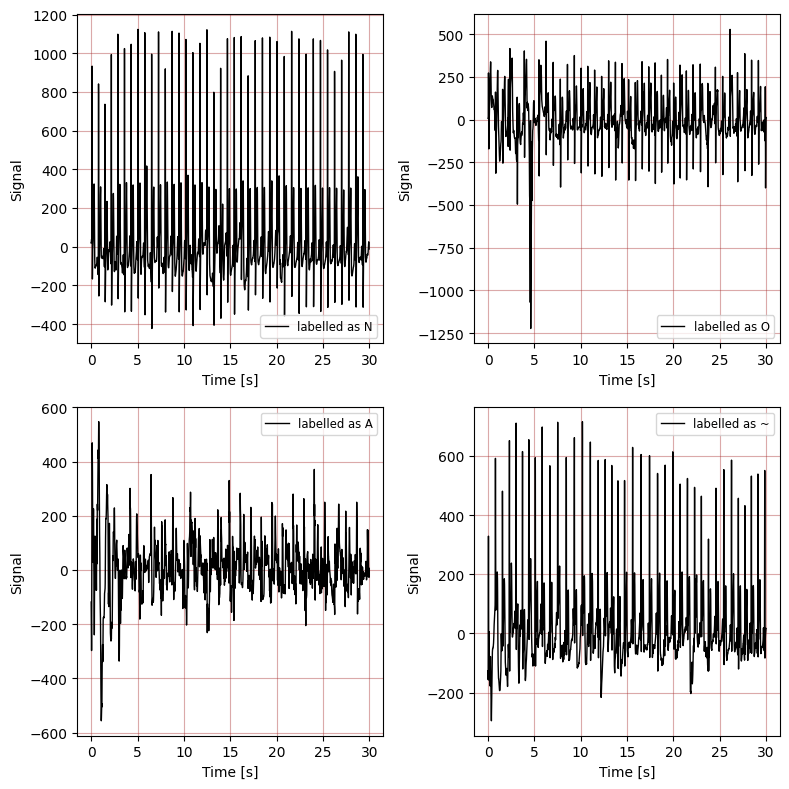

In [17]:
# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for ax, i in zip(axs.flatten(), plot_list):

  ax.plot(delta_t * np.arange(len(signals[i])), signals[i], label=f'labelled as {labels[i]}',
          linewidth=1, c='black')
  ax.legend(fontsize='small')
  ax.set_xlabel('Time [s]')
  ax.set_ylabel('Signal')
  ax.grid(True, c='brown', alpha=0.4)

plt.tight_layout()

Now let's see the amount of elements per class that we have:

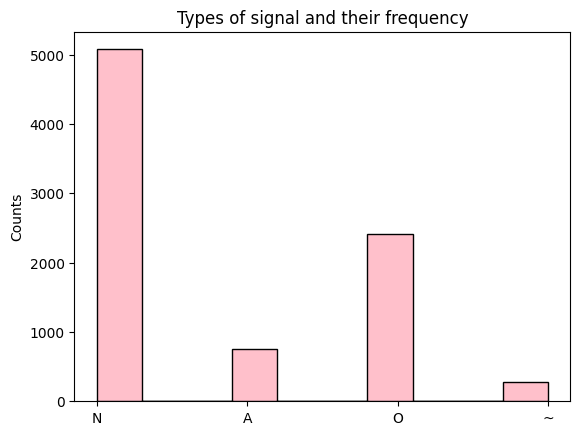

In [18]:
plt.hist(labels, histtype='stepfilled', edgecolor='black', facecolor='pink')
plt.title('Types of signal and their frequency')
plt.ylabel('Counts');

In [19]:
total_signals = len(signals)
N_signals = len(np.argwhere(labels == 'N'))
A_signals = len(np.argwhere(labels == 'A'))
O_signals = len(np.argwhere(labels == 'O'))
tilde_signals = len(np.argwhere(labels == '~'))

print('We have a', N_signals/total_signals * 100, '% N signals. \n')

print('The ratio with A signals is ', N_signals/A_signals, '.')
print('The ratio with O signals is ', N_signals/O_signals, '.')
print('The ratio with ~ signals is ', N_signals/tilde_signals, '.')

We have a 59.52157598499062 % N signals. 

The ratio with A signals is  6.696569920844327 .
The ratio with O signals is  2.101863354037267 .
The ratio with ~ signals is  18.193548387096776 .


In [20]:
# Find signals length

signals_length = [len(signals[i]) for i in range(0, len(signals))]

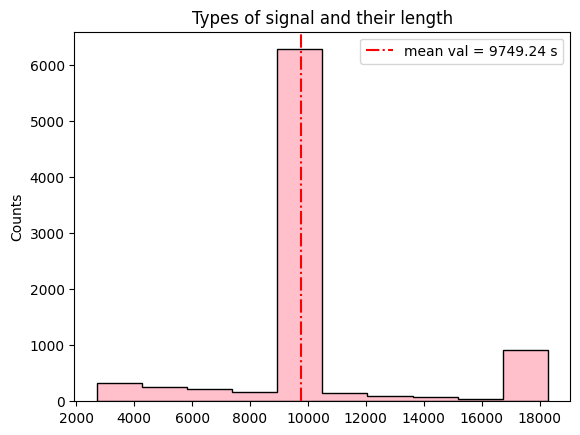

In [21]:
plt.hist(signals_length, histtype='stepfilled', edgecolor='black', facecolor='pink')
plt.title('Types of signal and their length')
plt.axvline(x=np.mean(signals_length), label=f'mean val = {np.mean(signals_length):.2f} s',
            linestyle='-.', c='red')
plt.ylabel('Counts')
plt.legend();

# $\textbf{Preprocessing the data}$

I here report the discussion on the topic of large $N$ with respect to other types of signals (see https://it.mathworks.com/help/deeplearning/ug/classify-ecg-signals-using-long-short-term-memory-networks.html for further details).

Because about 7/8 of the signals are $\textbf{normal}$ (N), the classifier would learn that it can achieve a high accuracy simply by classifying all signals as Normal. To avoid this bias, we need to augment the $\textbf{AFib}$ (A) data by duplicating AFib signals in the dataset so that there is the same number of Normal and AFib signals. This duplication, commonly called oversampling, is one form of data augmentation used in deep learning.

### $\textbf{Data segmentation}$

In [22]:
def segment_signals(signals, labels, segment_length=9000):
    """
    Segments the input signals into segments of a specified length and associates labels with them.

    Parameters:
    signals (list of list or 2D array): List of input signals where each signal is a list or 1D array.
    labels (list or 1D array): List of labels corresponding to each signal.
    segment_length (int): Length of each segment.

    Returns:
    np.ndarray: Array of segmented signals.
    np.ndarray: Array of labels corresponding to each segmented signal.
    """
    segmented_signals = []
    segmented_labels = []

    for signal, label in zip(signals, labels):
        signal_length = len(signal)
        if signal_length >= segment_length:
            num_segments = signal_length // segment_length
            for i in range(num_segments):
                start_idx = i * segment_length
                end_idx = start_idx + segment_length
                segment = signal[start_idx:end_idx]
                segmented_signals.append(segment)
                segmented_labels.append(label)  # Assign the same label to each segment

    return np.array(segmented_signals), np.array(segmented_labels)

In [23]:
segmented_signals, segmented_labels = segment_signals(signals, labels_for_NN, segment_length=9000)

In [24]:
afib_x = segmented_signals[np.where(segmented_labels == names_encoding['A'])[0]];
afib_y = segmented_labels[np.where(segmented_labels == names_encoding['A'])[0]];

normal_x = segmented_signals[np.where(segmented_labels == names_encoding['N'])[0]];
normal_y = segmented_labels[np.where(segmented_labels == names_encoding['N'])[0]];

other_x = segmented_signals[np.where(segmented_labels == names_encoding['O'])[0]];
other_y = segmented_labels[np.where(segmented_labels == names_encoding['O'])[0]];

noise_x = segmented_signals[np.where(segmented_labels == names_encoding['~'])[0]];
noise_y = segmented_labels[np.where(segmented_labels == names_encoding['~'])[0]];

In [25]:
# create intance of all data points, only first 2 for the moment

# Combine all data
all_x = np.concatenate((np.repeat(afib_x, 7, axis=0), normal_x))
all_y = np.concatenate((np.repeat(afib_y, 7, axis=0), normal_y))

# More generally we'll use:

#all_x = np.concatenate((afib_x, normal_x, other_x, noise_x), axis=0)
#all_y = np.concatenate((afib_y, normal_y, other_y, noise_y), axis=0)

### $\textbf{Data augmentation}$

The dataset is imbalanced. To achieve a similar number of AFib and Normal signals, repeat the AFib signals seven times.

By default, the neural network randomly shuffles the data before training, ensuring that contiguous signals do not all have the same label (siamo sicuri?).

Note that I will for the moment work only on two out of four labels to classify signals.

In [26]:
# Repeat arrays and concatenate the first two arrays for the moment

XTrain, XVal, YTrain, YVal = train_test_split(all_x, all_y, test_size=0.15, random_state=42)

In [27]:
# Print shapes:

print('X training: ', XTrain.shape)
print('X validation: ', XVal.shape)
print('Y training (labels): ', YTrain.shape)
print('Y validation (labels): ', YVal.shape)

X training:  (8653, 9000)
X validation:  (1528, 9000)
Y training (labels):  (8653, 1)
Y validation (labels):  (1528, 1)


In [28]:
# Standardize the data

data_mean_t = XTrain.mean(axis=0)
data_std_t = XTrain.std(axis=0)

data_mean_v = XVal.mean(axis=0)
data_std_v = YVal.std(axis=0)

XTrain = (XTrain - data_mean_t) / data_std_t
XVal = (XVal - data_mean_v) / data_std_v

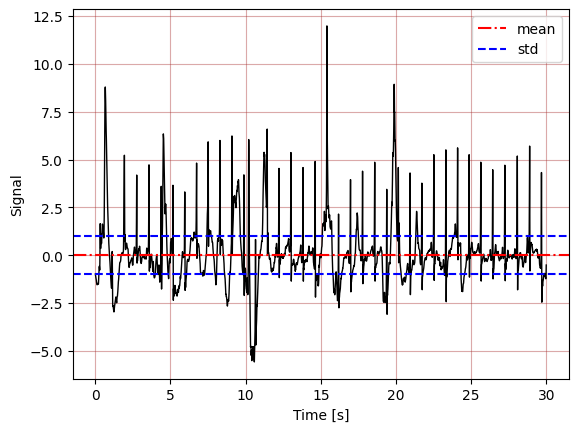

In [29]:
# Check on one plot

plt.plot(delta_t * np.arange(len(XTrain[0])), XTrain[0], linewidth=1, c='black')
plt.axhline(y=XTrain.mean(axis=0)[0], c='red', linestyle='-.', label='mean')
plt.axhline(y=XTrain.std(axis=0)[0], c='blue', linestyle='--', label='std')
plt.axhline(y=-XTrain.std(axis=0)[0], c='blue', linestyle='--')

plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.grid(True, c='brown', alpha=0.4);

In [30]:
# Check balance of features now

unique, counts = np.unique(YTrain, return_counts=True)
unique_val, counts_val = np.unique(YVal, return_counts=True)

print('Training', unique, ' ', counts)
print('Validation', unique_val, ' ', counts_val)

Training [0 1]   [4450 4203]
Validation [0 1]   [793 735]


# $\textbf{Building the architecture of the NN}$

I here report only my first attempt to train and run a network based only on two out of the four labels.

In [39]:
# Define the architecture of the NN
input_shape = (9000, 1)  # Each input is a sequence of 9000 timesteps with 1 feature per timestep

inputs = keras.layers.Input(shape=input_shape)
x = inputs

# Add convolutional layers to extract spatial features
x = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)
x = keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling1D(pool_size=2)(x)

# Add bidirectional LSTM layers with dropout
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Bidirectional(keras.layers.LSTM(128))(x)
x = keras.layers.Dropout(0.5)(x)

# Add fully connected layers
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)

# Add final output layer
outputs = keras.layers.Dense(2, activation='softmax')(x)

 Define the architecture of the NN

input_shape = (9000, 1)

inputs = keras.layers.Input(shape=input_shape)
x = inputs
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dense(2, activation='softmax')(x)
outputs = x
net = keras.Model(inputs=inputs, outputs=outputs)

In [40]:
# Create the model
net = keras.Model(inputs=inputs, outputs=outputs)

In [41]:
# Compile the model

learning_rate = 0.001
epochs = 5

net.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8998, 64)          256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4499, 64)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 4497, 128)         24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2248, 128)         0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 2248, 256)         2631

## $\textbf{Training the NN}$

In [43]:
# Callbacks for early stopping and learning rate reduction
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [44]:
# Train the model with callbacks

history = net.fit(
    x=XTrain,
    y=YTrain,
    epochs=epochs,
    validation_data=(XVal, YVal),
    callbacks=[early_stopping, lr_reduction],
    batch_size=128
)

Epoch 1/5
68/68 [==============================] - 69s 820ms/step - loss: 1.5332 - accuracy: 0.5159 - val_loss: 1.0951 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 2/5
68/68 [==============================] - 52s 760ms/step - loss: 0.9209 - accuracy: 0.5149 - val_loss: 0.8049 - val_accuracy: 0.5039 - lr: 0.0010
Epoch 3/5
 8/68 [==>...........................] - ETA: 42s - loss: 0.7975 - accuracy: 0.5156

KeyboardInterrupt: 

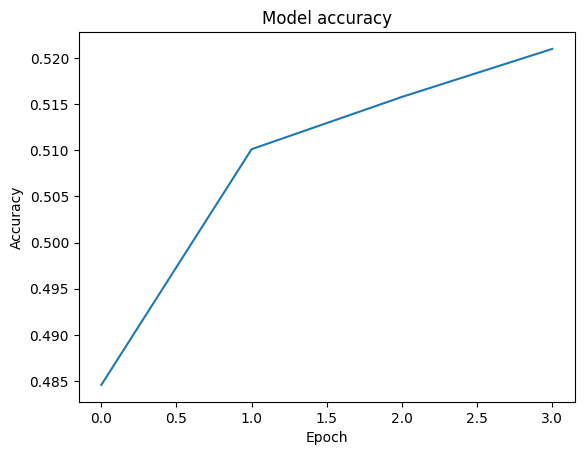

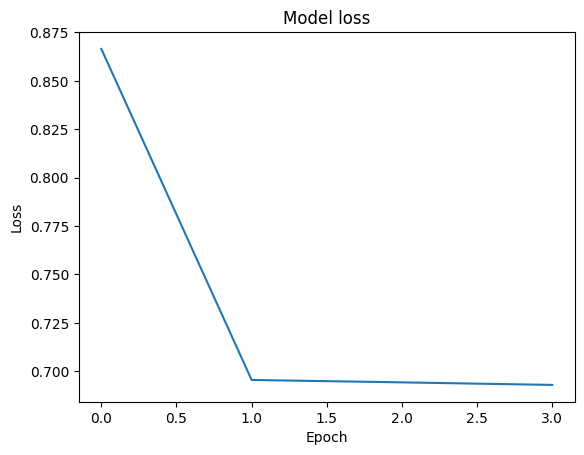

In [37]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()